### step-01,installing dependenncies

In [1]:
pip install tensorflow==2.10.0 tensorflow-gpu==2.10.0 opencv-python matplotlib


Note: you may need to restart the kernel to use updated packages.


### step-02, import dependecies

In [2]:
import cv2 #computer vision, collecting images thorugh webcam
import os
import random
import numpy as np#helps working with tensors, array transformation
from matplotlib import pyplot as plt
import shutil

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model # un, used to define input and output in model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### step-03, setting GPU Growth

In [4]:
#avoid oom errors by setting GPU memory COnsumption Growth
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### step-4, create folder structures

In [12]:
#setting up the paths

POS_PATH= os.path.join('data', 'positive')
NEG_PATH= os.path.join('data', 'negative')
ANC_PATH= os.path.join('data', 'anchor')

In [13]:
#making directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

### 2. Collect Positives and Anchors

In [10]:
# http://vis-www.cs.umass.edu/lfw/


In [14]:
#movin lfw imagees to negative repo data/negative

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH=os.path.join('lfw', directory, file)
        NEW_PATH=os.path.join(NEG_PATH, file)
        shutil.move(EX_PATH, NEG_PATH) #move from old path to the new path

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

### step 2.1, collect positives and anchor classes

In [6]:
import uuid #to generate unique image name

In [7]:
uuid.uuid1()

UUID('8a5132f8-df7d-11ee-b3cb-f42679727d91')

In [15]:
cap =cv2.VideoCapture(0) #connection to videocam
while cap.isOpened():
    ret, frame=cap.read() #reading the captured image

    #adjusting the frame size according to our requirements, 250*250px
    frame=frame[200:200+250, 200:180+250, :]

    #colllect anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        #creating unique name
        imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        #creating unique name
        imgname=os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    
    cv2.imshow('Image Collection', frame) #rendering the image

    #breaking gracefully
    if cv2.waitKey(1) & 0XFF==ord('q'): #gonna wait for 1 milisecond and check which key is pressed 
        break

#release the webcam
cap.release()
cv2.destroyAllWindows()



## preparing the data for deep learning



step 3.1, getting image directories

In [19]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(100) #to grab all the image files in the specified directory
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(100) #take(100) mean we will be using 100 images from the dataset
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(100)

In [20]:
dir_test= anchor.as_numpy_iterator()

In [21]:
dir_test.next()

b'data\\anchor\\5a9659eb-deb0-11ee-96f1-f42679727d91.jpg'

step 3.2, preprocessing -scale and resize

In [22]:
def preprocess(file_path):
    #read image from dataset
    byte_img= tf.io.read_file(file_path)
    
    #load in the image
    img=tf.io.decode_jpeg(byte_img)
    
    #preprocessing the image, adjusting pixels and shape, size
    img=tf.image.resize(img, (100, 100))
    
    #scaling the image between 0 and 1, to help us in gradient descent and help us optmize the model
    img=img/255.0
    return img



In [23]:
img=preprocess('data\\anchor\\3d97cb21-deb0-11ee-ae75-f42679727d91.jpg')

In [24]:
img.numpy().max()

1.0

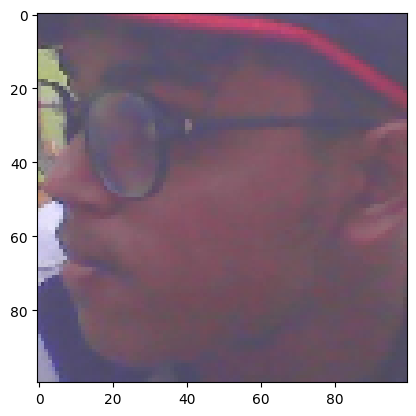

In [25]:
plt.imshow(img)

### step-3.3, CREATING LABELLED DATASET

In [26]:
#(anchor, positive)=> 1, 1, 1, 1, 1
#(anchor, negative)=> 0, 0, 0, 0, 0


In [27]:
positives=tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [28]:
samples= data.as_numpy_iterator()

In [29]:
exampple=samples.next()

## step-3.4, build Train and Test Partition

In [30]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [31]:
res=preprocess_twin(*exampple)

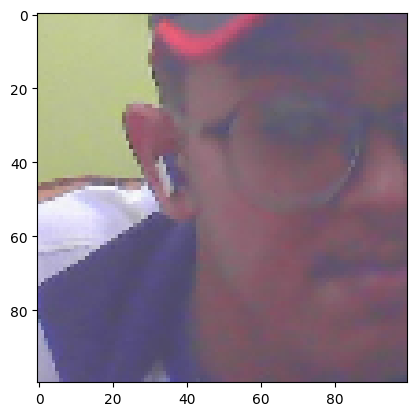

In [32]:
plt.imshow(res[0])

In [33]:
res[2]

1.0

In [34]:
#build dataloader pipeline

data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024) #mixes up all the dataset


In [35]:
samples= data.as_numpy_iterator()

In [36]:
len(samples.next())

3

In [37]:
samp=samples.next()

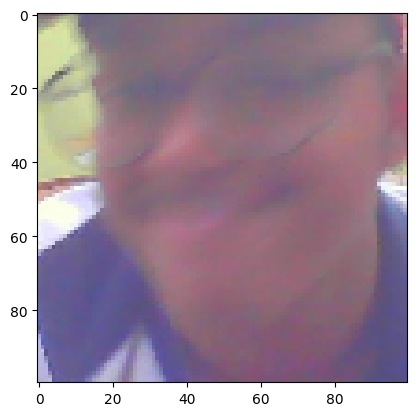

In [38]:
plt.imshow(samp[0])

In [39]:
#training partition
train_data=data.take(round(len(data)*7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [40]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [41]:
train_samples= train_data.as_numpy_iterator()

In [42]:
train_sample= train_samples.next()

In [43]:
len(train_sample[0])

16

In [44]:
#testing partition
test_data= data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.prefetch

1. build and embedding layer
2. create an l1 distance layer
3. compile the siamese network

## Model Engineering

step-01, building embedding layer

In [45]:
inp=Input(shape=(100, 100, 3))

In [46]:
c1= Conv2D(64, (10, 10), activation='relu')(inp) #all the info is referenced from relu


In [47]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [48]:
m1= MaxPooling2D(64, (2, 2), padding='same')(c1)


In [49]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [50]:
c2=Conv2D(128, (7, 7), activation='relu')(m1)
m2=MaxPooling2D(64, (2, 2), padding='same')(c2)

In [51]:
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [52]:
c3 = Conv2D(128, (4,4), activation='relu')(m2) #we need 128 filters with the shape 4*4
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


In [53]:
c3

<KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'conv2d_2')>

In [54]:
c4=Conv2D(128, (4, 4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [55]:
f1

<KerasTensor: shape=(None, 4608) dtype=float32 (created by layer 'flatten')>

In [56]:
mod=Model(inputs=[inp], outputs=[d1], name='embedding')

In [57]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [59]:
def make_embedding():
    inp=Input(shape=(100, 100, 3), name='input_image')
    
    #first block
    c1= Conv2D(64, (10, 10), activation='relu')(inp) #all the info is referenced from relu
    m1= MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    #second block
    c2=Conv2D(128, (7, 7), activation='relu')(m1)
    m2=MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2) #we need 128 filters with the shape 4*4
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #fourth block
    c4=Conv2D(128, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [71]:
embedding=make_embedding()

## building a distance layer

In [63]:
#siamese l1 distance class

class L1Dist(Layer):
    def __init__(self, **kwargs): #allows us to wkr with these specifc layer
        super().__init__()

    #magic happens here, -->similarity calculation
    def call(self, input_embedding, validation_embedding):#first river, second river 
        return tf.math.abs(input_embedding - validation_embedding) #returns an absolute value

In [65]:
l1=L1Dist()

In [67]:
l1(anchor_embedding, validation_embedding)


NameError: name 'anchor_embedding' is not defined

## making siamese model

In [68]:
input_image= Input(name='input_img', shape=(100, 100, 3))

In [77]:
inp_embedding=embedding(input_image)
val_embedding=embedding(validation_image)

NameError: name 'validation_image' is not defined

In [75]:
val_embedding

NameError: name 'val_embedding' is not defined

In [79]:
siamese_network=Model(inputs=[input_image, validation_img], outputs=classifier, name='SiameseNetwork')

NameError: name 'validation_img' is not defined

In [80]:
siamese_network

NameError: name 'siamese_network' is not defined

In [78]:
def make_siamese_model():

    #handling inputs
    input_image= Input(name="input_img", shape=(100, 100, 3))
    
    #validation image in the network
    validation_img=Input(name='validation_img', shape=(100, 100, 3))

    #combing siamese distancing componenets

    siamese_layer= L1Dist()
    siamese_layer.name='distance'
    distances= siamese_layer(embedding(input_image), embedding(validation_image))

    #classification of layer
    classifier=Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_img], outputs=classifier, name='SiameseNetwork')